<a href="https://colab.research.google.com/github/kodagabriel/tp_PDI/blob/main/oneshot_learning_face_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
 Instalations
!pip install mtcnn

     |████████████████████████████████| 2.3MB 5.3MB/s 


In [ ]:
 Imports
from os import listdir
from PIL import Image
from numpy import asarray
from numpy import savez_compressed
from numpy import load
from matplotlib import pyplot
from mtcnn.mtcnn import MTCNN
from os.path import isdir
from numpy import expand_dims
from keras.models import load_model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
 extract a single face from a given photograph
def extract_face(filename, required_size=(160, 160)):
	 load image from file
	image = Image.open(filename)
	 convert to RGB, if needed
	image = image.convert('RGB')
	 convert to array
	pixels = asarray(image)
	 create the detector, using default weights
	detector = MTCNN()
	 detect faces in the image
	results = detector.detect_faces(pixels)
	 extract the bounding box from the first face
	x1, y1, width, height = results[0]['box']
	 bug fix
	x1, y1 = abs(x1), abs(y1)
	x2, y2 = x1 + width, y1 + height
	 extract the face
	face = pixels[y1:y2, x1:x2]
	 resize pixels to the model size
	image = Image.fromarray(face)
	image = image.resize(required_size)
	face_array = asarray(image)
	return face_array


In [ ]:
 extract a single face from a given photograph
def extract_faces(filename, required_size=(160, 160)):
	 load image from file
	image = Image.open(filename)
	 convert to RGB, if needed
	image = image.convert('RGB')
	 convert to array
	pixels = asarray(image)
	 create the detector, using default weights
	detector = MTCNN()
	 detect faces in the image
	results = detector.detect_faces(pixels)
	faces = list()
	for result in results: 
     extract the bounding box from the first face
		x1, y1, width, height = result['box']
     bug fix
		x1, y1 = abs(x1), abs(y1)
		x2, y2 = x1 + width, y1 + height
     extract the face
		face = pixels[y1:y2, x1:x2]
     resize pixels to the model size
		image = Image.fromarray(face)
		image = image.resize(required_size)
		face_array = asarray(image)
		faces.append(face_array)
	return asarray(faces)


In [ ]:
def load_faces(directory):
	faces = list()
	 enumerate files
	for filename in listdir(directory):
		 path
		path = directory + filename
		 get face
		face = extract_face(path)
		 store
		faces.append(face)
	return faces

In [ ]:
 load a dataset that contains one subdir for each class that in turn contains images
def load_dataset(directory):
	X, y = list(), list()
	 enumerate folders, on per class
	for subdir in listdir(directory):
		 path
		path = directory + subdir + '/'
		 skip any files that might be in the dir
		if not isdir(path):
			continue
		 load all faces in the subdirectory
		faces = load_faces(path)
		 create labels
		labels = [subdir for _ in range(len(faces))]
		 summarize progress
		print('>loaded %d examples for class: %s' % (len(faces), subdir))
		 store
		X.extend(faces)
		y.extend(labels)
	return asarray(X), asarray(y)

In [ ]:
 load train dataset
trainX, trainy = load_dataset('/content/drive/MyDrive/PDI2/train/')
print(trainX.shape, trainy.shape)
 load test dataset
testX, testy = load_dataset('/content/drive/MyDrive/PDI/test/')
print(testX.shape, testy.shape)
 save arrays to one file in compressed format
savez_compressed('classification-dataset.npz', trainX, trainy, testX, testy)

In [ ]:
 calculate a face embedding for each face in the dataset using facenet
 get the face embedding for one face
def get_embedding(model, face_pixels):
	 scale pixel values
	face_pixels = face_pixels.astype('float32')
	 standardize pixel values across channels (global)
	mean, std = face_pixels.mean(), face_pixels.std()
	face_pixels = (face_pixels - mean) / std
	 transform face into one sample
	samples = expand_dims(face_pixels, axis=0)
	 make prediction to get embedding
	yhat = model.predict(samples)
	return yhat[0]

In [ ]:
 load the face dataset
data = load('classification-dataset.npz', allow_pickle=True)
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Loaded: ', trainX.shape, trainy.shape, testX.shape, testy.shape)
 load the facenet model
model = load_model('/content/drive/MyDrive/PDI/facenet_keras.h5')
print('Loaded Model')
 convert each face in the train set to an embedding
newTrainX = list()
for face_pixels in trainX:
	embedding = get_embedding(model, face_pixels)
	newTrainX.append(embedding)
newTrainX = asarray(newTrainX)
print(newTrainX.shape)
 convert each face in the test set to an embedding
newTestX = list()
for face_pixels in testX:
	embedding = get_embedding(model, face_pixels)
	newTestX.append(embedding)
newTestX = asarray(newTestX)
print(newTestX.shape)
 save arrays to one file in compressed format
savez_compressed('classification-embeddings.npz', newTrainX, trainy, newTestX, testy)

Loaded:  (16, 160, 160, 3) (16,) (96, 160, 160, 3) (96,)
Loaded Model
(16, 128)
(96, 128)


In [ ]:
 develop a classifier for the 5 Celebrity Faces Dataset
from numpy import load
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
 load dataset
data = load('classification-embeddings.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Dataset: train=%d, test=%d' % (trainX.shape[0], testX.shape[0]))
 normalize input vectors
in_encoder = Normalizer(norm='l2')
trainX = in_encoder.transform(trainX)
testX = in_encoder.transform(testX)
 label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
testy = out_encoder.transform(testy)
 fit model
model = SVC(kernel='linear', probability=True)
model.fit(trainX, trainy)
 predict
yhat_train = model.predict(trainX)
yhat_test = model.predict(testX)
 score
score_train = accuracy_score(trainy, yhat_train)
score_test = accuracy_score(testy, yhat_test)
 summarize
print('Accuracy: train=%.3f, test=%.3f' % (score_train*100, score_test*100))

Dataset: train=16, test=96
Accuracy: train=100.000, test=96.875


Predicted: war_machine (3.769)
Expected: war_machine


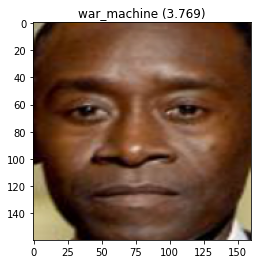

In [ ]:
 develop a classifier for the 5 Celebrity Faces Dataset
from random import choice
from numpy import load
from numpy import expand_dims
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
from matplotlib import pyplot
 load faces
data = load('classification-dataset.npz')
testX_faces = data['arr_2']
 load face embeddings
data = load('classification-embeddings.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
 normalize input vectors
in_encoder = Normalizer(norm='l2')
trainX = in_encoder.transform(trainX)
testX = in_encoder.transform(testX)
 label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
testy = out_encoder.transform(testy)
 fit model
model = SVC(kernel='linear', probability=True)
model.fit(trainX, trainy)
 test model on a random example from the test dataset
selection = choice([i for i in range(testX.shape[0])])
random_face_pixels = testX_faces[selection]
random_face_emb = testX[selection]
random_face_class = testy[selection]
random_face_name = out_encoder.inverse_transform([random_face_class])
 prediction for the face
samples = expand_dims(random_face_emb, axis=0)
yhat_class = model.predict(samples)
yhat_prob = model.predict_proba(samples)
 get name
class_index = yhat_class[0]
class_probability = yhat_prob[0,class_index] * 100
predict_names = out_encoder.inverse_transform(yhat_class)
print('Predicted: %s (%.3f)' % (predict_names[0], class_probability))
print('Expected: %s' % random_face_name[0])
 plot for fun
pyplot.imshow(random_face_pixels)
title = '%s (%.3f)' % (predict_names[0], class_probability)
pyplot.title(title)
pyplot.show()

In [ ]:
 develop a classifier for the 5 Celebrity Faces Dataset
from random import choice
from numpy import load
from numpy import expand_dims
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
from matplotlib import pyplot
 load faces
data = load('classification-dataset.npz')
testX_faces = data['arr_2']
 load face embeddings
data = load('classification-embeddings.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
 normalize input vectors
in_encoder = Normalizer(norm='l2')
trainX = in_encoder.transform(trainX)
testX = in_encoder.transform(testX)
 label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
testy = out_encoder.transform(testy)
 fit model
model = SVC(kernel='linear', probability=True)
model.fit(trainX, trainy)


class_faces = extract_faces('/content/drive/MyDrive/PDI/classroom/class1.jpg')
class1ExpectedResult = {
    "ant_man": True,
    "capitao_america": True,
    "drax": True,
    "falcao": True,
    "gamora": True,
    "gaviao_arqueiro": True,
    "homem_aranha": True,
    "hulk": True,
    "ironman": True,
    "pantera_negra": True,
    "star_lord": True,
    "strange": True,
    "thor": True,
    "viuva_negra": True,
    "wanda": True,
    "war_machine": True
}

class1Results = {
    "ant_man": False,
    "capitao_america": False,
    "drax": False,
    "falcao": False,
    "gamora": False,
    "gaviao_arqueiro": False,
    "homem_aranha": False,
    "hulk": False,
    "ironman": False,
    "pantera_negra": False,
    "star_lord": False,
    "strange": False,
    "thor": False,
    "viuva_negra": False,
    "wanda": False,
    "war_machine": False
}
classroom = list()

model2 = load_model('/content/drive/MyDrive/PDI/facenet_keras.h5')
for face_pixels in class_faces:
	print(face_pixels.shape)
	embedding = get_embedding(model2, face_pixels)
	classroom.append(embedding)
 
classroom = asarray(classroom)
in_encoder = Normalizer(norm='l2')
faces = in_encoder.transform(classroom)
cont = 0
for face in faces:
   prediction for the face
  samples = expand_dims(face, axis=0)
  yhat_class = model.predict(samples)
  yhat_prob = model.predict_proba(samples)
   get name
  class_index = yhat_class[0]
  class_probability = yhat_prob[0,class_index] * 100
  predict_names = out_encoder.inverse_transform(yhat_class)
   print('Predicted: %s (%.3f)' % (predict_names[0], class_probability))
   plot for fun
  title = '%s (%.3f)' % (predict_names[0], class_probability)
  class1Results[predict_names[0]] = True
   pyplot.title(title)
   pyplot.imshow(class_faces[cont])
   pyplot.show()
  cont += 1
print (class1ExpectedResult)
print (class1Results)
total = len(class1ExpectedResult)
corrects = 0
false_positives = 0
false_negatives = 0
for key in class1ExpectedResult:
  if class1Results[key] == class1ExpectedResult[key]: 
    corrects += 1
  elif class1Results[key] == True:
      false_positives += 1
  else: 
      false_negatives += 1 

print("Acertou %.3f" % (corrects/total * 100))
print("Falsos positivos %.3f" % (false_positives/total * 100))
print("Falsos negativos %.3f" % (false_negatives/total * 100))

print("Total %f" % (sum(class1ExpectedResult.values())))

(160, 160, 3)
(160, 160, 3)
(160, 160, 3)
(160, 160, 3)
(160, 160, 3)
(160, 160, 3)
(160, 160, 3)
(160, 160, 3)
(160, 160, 3)
(160, 160, 3)
(160, 160, 3)
(160, 160, 3)
(160, 160, 3)
(160, 160, 3)
(160, 160, 3)
(160, 160, 3)
(160, 160, 3)
(160, 160, 3)
(160, 160, 3)
{'ant_man': True, 'capitao_america': True, 'drax': True, 'falcao': True, 'gamora': True, 'gaviao_arqueiro': True, 'homem_aranha': True, 'hulk': True, 'ironman': True, 'pantera_negra': True, 'star_lord': True, 'strange': True, 'thor': True, 'viuva_negra': True, 'wanda': True, 'war_machine': True}
{'ant_man': True, 'capitao_america': True, 'drax': True, 'falcao': True, 'gamora': True, 'gaviao_arqueiro': True, 'homem_aranha': False, 'hulk': True, 'ironman': True, 'pantera_negra': True, 'star_lord': True, 'strange': True, 'thor': True, 'viuva_negra': True, 'wanda': True, 'war_machine': True}
Acertou 93.750
Falsos positivos 0.000
Falsos negativos 6.250
Total 16.000000


In [ ]:
 develop a classifier for the 5 Celebrity Faces Dataset
from random import choice
from numpy import load
from numpy import expand_dims
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
from matplotlib import pyplot
 load faces
data = load('classification-dataset.npz')
testX_faces = data['arr_2']
 load face embeddings
data = load('classification-embeddings.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
 normalize input vectors
in_encoder = Normalizer(norm='l2')
trainX = in_encoder.transform(trainX)
testX = in_encoder.transform(testX)
 label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
testy = out_encoder.transform(testy)
 fit model
model = SVC(kernel='linear', probability=True)
model.fit(trainX, trainy)


class_faces = extract_faces('/content/drive/MyDrive/PDI/classroom/class2.jpeg')
class1ExpectedResult = {
    "ant_man": False,
    "capitao_america": True,
    "drax": False,
    "falcao": False,
    "gamora": False,
    "gaviao_arqueiro": True,
    "homem_aranha": False,
    "hulk": False,
    "ironman": True,
    "pantera_negra": False,
    "star_lord": False,
    "strange": False,
    "thor": True,
    "viuva_negra": True,
    "wanda": False,
    "war_machine": False
}

class1Results = {
    "ant_man": False,
    "capitao_america": False,
    "drax": False,
    "falcao": False,
    "gamora": False,
    "gaviao_arqueiro": False,
    "homem_aranha": False,
    "hulk": False,
    "ironman": False,
    "pantera_negra": False,
    "star_lord": False,
    "strange": False,
    "thor": False,
    "viuva_negra": False,
    "wanda": False,
    "war_machine": False
}
classroom = list()

model2 = load_model('/content/drive/MyDrive/PDI/facenet_keras.h5')
for face_pixels in class_faces:
	print(face_pixels.shape)
	embedding = get_embedding(model2, face_pixels)
	classroom.append(embedding)
 
classroom = asarray(classroom)
in_encoder = Normalizer(norm='l2')
faces = in_encoder.transform(classroom)
cont = 0
for face in faces:
   prediction for the face
  samples = expand_dims(face, axis=0)
  yhat_class = model.predict(samples)
  yhat_prob = model.predict_proba(samples)
   get name
  class_index = yhat_class[0]
  class_probability = yhat_prob[0,class_index] * 100
  predict_names = out_encoder.inverse_transform(yhat_class)
   print('Predicted: %s (%.3f)' % (predict_names[0], class_probability))
   plot for fun
  title = '%s (%.3f)' % (predict_names[0], class_probability)
  class1Results[predict_names[0]] = True
   pyplot.title(title)
   pyplot.imshow(class_faces[cont])
   pyplot.show()
  cont += 1
print (class1ExpectedResult)
print (class1Results)
total = len(class1ExpectedResult)
corrects = 0
false_positives = 0
false_negatives = 0
for key in class1ExpectedResult:
  if class1Results[key] == class1ExpectedResult[key]: 
    corrects += 1
  elif class1Results[key] == True:
      false_positives += 1
  else: 
      false_negatives += 1 

print("Acertou %.3f" % (corrects/total * 100))
print("Falsos positivos %.3f" % (false_positives/total * 100))
print("Falsos negativos %.3f" % (false_negatives/total * 100))

print("Total %f" % (sum(class1ExpectedResult.values())))

(160, 160, 3)
(160, 160, 3)
(160, 160, 3)
(160, 160, 3)
(160, 160, 3)
{'ant_man': False, 'capitao_america': True, 'drax': False, 'falcao': False, 'gamora': False, 'gaviao_arqueiro': True, 'homem_aranha': False, 'hulk': False, 'ironman': True, 'pantera_negra': False, 'star_lord': False, 'strange': False, 'thor': True, 'viuva_negra': True, 'wanda': False, 'war_machine': False}
{'ant_man': False, 'capitao_america': True, 'drax': False, 'falcao': False, 'gamora': False, 'gaviao_arqueiro': True, 'homem_aranha': False, 'hulk': False, 'ironman': True, 'pantera_negra': False, 'star_lord': False, 'strange': False, 'thor': True, 'viuva_negra': True, 'wanda': False, 'war_machine': False}
Acertou 100.000
Falsos positivos 0.000
Falsos negativos 0.000
Total 5.000000


In [ ]:
 develop a classifier for the 5 Celebrity Faces Dataset
from random import choice
from numpy import load
from numpy import expand_dims
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
from matplotlib import pyplot
 load faces
data = load('classification-dataset.npz')
testX_faces = data['arr_2']
 load face embeddings
data = load('classification-embeddings.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
 normalize input vectors
in_encoder = Normalizer(norm='l2')
trainX = in_encoder.transform(trainX)
testX = in_encoder.transform(testX)
 label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
testy = out_encoder.transform(testy)
 fit model
model = SVC(kernel='linear', probability=True)
model.fit(trainX, trainy)


class_faces = extract_faces('/content/drive/MyDrive/PDI/classroom/class3.jpeg')
class1ExpectedResult = {
    "ant_man": False,
    "capitao_america": True,
    "drax": False,
    "falcao": False,
    "gamora": False,
    "gaviao_arqueiro": True,
    "homem_aranha": False,
    "hulk": True,
    "ironman": True,
    "pantera_negra": False,
    "star_lord": False,
    "strange": False,
    "thor": True,
    "viuva_negra": True,
    "wanda": False,
    "war_machine": False
}

class1Results = {
    "ant_man": False,
    "capitao_america": False,
    "drax": False,
    "falcao": False,
    "gamora": False,
    "gaviao_arqueiro": False,
    "homem_aranha": False,
    "hulk": False,
    "ironman": False,
    "pantera_negra": False,
    "star_lord": False,
    "strange": False,
    "thor": False,
    "viuva_negra": False,
    "wanda": False,
    "war_machine": False
}
classroom = list()

model2 = load_model('/content/drive/MyDrive/PDI/facenet_keras.h5')
for face_pixels in class_faces:
	print(face_pixels.shape)
	embedding = get_embedding(model2, face_pixels)
	classroom.append(embedding)
 
classroom = asarray(classroom)
in_encoder = Normalizer(norm='l2')
faces = in_encoder.transform(classroom)
cont = 0
for face in faces:
   prediction for the face
  samples = expand_dims(face, axis=0)
  yhat_class = model.predict(samples)
  yhat_prob = model.predict_proba(samples)
   get name
  class_index = yhat_class[0]
  class_probability = yhat_prob[0,class_index] * 100
  predict_names = out_encoder.inverse_transform(yhat_class)
   print('Predicted: %s (%.3f)' % (predict_names[0], class_probability))
   plot for fun
  title = '%s (%.3f)' % (predict_names[0], class_probability)
  class1Results[predict_names[0]] = True
   pyplot.title(title)
   pyplot.imshow(class_faces[cont])
   pyplot.show()
  cont += 1
print (class1ExpectedResult)
print (class1Results)
total = len(class1ExpectedResult)
corrects = 0
false_positives = 0
false_negatives = 0
for key in class1ExpectedResult:
  if class1Results[key] == class1ExpectedResult[key]: 
    corrects += 1
  elif class1Results[key] == True:
      false_positives += 1
  else: 
      false_negatives += 1 

print("Acertou %.3f" % (corrects/total * 100))
print("Falsos positivos %.3f" % (false_positives/total * 100))
print("Falsos negativos %.3f" % (false_negatives/total * 100))

print("Total %f" % (sum(class1ExpectedResult.values())))

(160, 160, 3)
(160, 160, 3)
(160, 160, 3)
(160, 160, 3)
(160, 160, 3)
(160, 160, 3)
(160, 160, 3)
(160, 160, 3)
(160, 160, 3)
{'ant_man': False, 'capitao_america': True, 'drax': False, 'falcao': False, 'gamora': False, 'gaviao_arqueiro': True, 'homem_aranha': False, 'hulk': True, 'ironman': True, 'pantera_negra': False, 'star_lord': False, 'strange': False, 'thor': True, 'viuva_negra': True, 'wanda': False, 'war_machine': False}
{'ant_man': True, 'capitao_america': True, 'drax': False, 'falcao': False, 'gamora': False, 'gaviao_arqueiro': True, 'homem_aranha': False, 'hulk': True, 'ironman': True, 'pantera_negra': False, 'star_lord': False, 'strange': False, 'thor': True, 'viuva_negra': True, 'wanda': True, 'war_machine': False}
Acertou 87.500
Falsos positivos 12.500
Falsos negativos 0.000
Total 6.000000


In [ ]:
 develop a classifier for the 5 Celebrity Faces Dataset
from random import choice
from numpy import load
from numpy import expand_dims
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
from matplotlib import pyplot
 load faces
data = load('classification-dataset.npz')
testX_faces = data['arr_2']
 load face embeddings
data = load('classification-embeddings.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
 normalize input vectors
in_encoder = Normalizer(norm='l2')
trainX = in_encoder.transform(trainX)
testX = in_encoder.transform(testX)
 label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
testy = out_encoder.transform(testy)
 fit model
model = SVC(kernel='linear', probability=True)
model.fit(trainX, trainy)


class_faces = extract_faces('/content/drive/MyDrive/PDI/classroom/class4.jpeg')
class1ExpectedResult = {
    "ant_man": False,
    "capitao_america": True,
    "drax": False,
    "falcao": False,
    "gamora": False,
    "gaviao_arqueiro": True,
    "homem_aranha": False,
    "hulk": True,
    "ironman": False,
    "pantera_negra": False,
    "star_lord": False,
    "strange": False,
    "thor": True,
    "viuva_negra": True,
    "wanda": False,
    "war_machine": False
}

class1Results = {
    "ant_man": False,
    "capitao_america": False,
    "drax": False,
    "falcao": False,
    "gamora": False,
    "gaviao_arqueiro": False,
    "homem_aranha": False,
    "hulk": False,
    "ironman": False,
    "pantera_negra": False,
    "star_lord": False,
    "strange": False,
    "thor": False,
    "viuva_negra": False,
    "wanda": False,
    "war_machine": False
}
classroom = list()

model2 = load_model('/content/drive/MyDrive/PDI/facenet_keras.h5')
for face_pixels in class_faces:
	print(face_pixels.shape)
	embedding = get_embedding(model2, face_pixels)
	classroom.append(embedding)
 
classroom = asarray(classroom)
in_encoder = Normalizer(norm='l2')
faces = in_encoder.transform(classroom)
cont = 0
for face in faces:
   prediction for the face
  samples = expand_dims(face, axis=0)
  yhat_class = model.predict(samples)
  yhat_prob = model.predict_proba(samples)
   get name
  class_index = yhat_class[0]
  class_probability = yhat_prob[0,class_index] * 100
  predict_names = out_encoder.inverse_transform(yhat_class)
   print('Predicted: %s (%.3f)' % (predict_names[0], class_probability))
   plot for fun
  title = '%s (%.3f)' % (predict_names[0], class_probability)
  class1Results[predict_names[0]] = True
   pyplot.title(title)
   pyplot.imshow(class_faces[cont])
   pyplot.show()
  cont += 1
print (class1ExpectedResult)
print (class1Results)
total = len(class1ExpectedResult)
corrects = 0
false_positives = 0
false_negatives = 0
for key in class1ExpectedResult:
  if class1Results[key] == class1ExpectedResult[key]: 
    corrects += 1
  elif class1Results[key] == True:
      false_positives += 1
  else: 
      false_negatives += 1 

print("Acertou %.3f" % (corrects/total * 100))
print("Falsos positivos %.3f" % (false_positives/total * 100))
print("Falsos negativos %.3f" % (false_negatives/total * 100))

print("Total %f" % (sum(class1ExpectedResult.values())))

(160, 160, 3)
(160, 160, 3)
(160, 160, 3)
(160, 160, 3)
(160, 160, 3)
(160, 160, 3)
(160, 160, 3)
{'ant_man': False, 'capitao_america': True, 'drax': False, 'falcao': False, 'gamora': False, 'gaviao_arqueiro': True, 'homem_aranha': False, 'hulk': True, 'ironman': False, 'pantera_negra': False, 'star_lord': False, 'strange': False, 'thor': True, 'viuva_negra': True, 'wanda': False, 'war_machine': False}
{'ant_man': False, 'capitao_america': True, 'drax': False, 'falcao': False, 'gamora': False, 'gaviao_arqueiro': True, 'homem_aranha': True, 'hulk': True, 'ironman': False, 'pantera_negra': False, 'star_lord': False, 'strange': False, 'thor': False, 'viuva_negra': False, 'wanda': True, 'war_machine': False}
Acertou 75.000
Falsos positivos 12.500
Falsos negativos 12.500
Total 5.000000


In [ ]:
 develop a classifier for the 5 Celebrity Faces Dataset
from random import choice
from numpy import load
from numpy import expand_dims
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
from matplotlib import pyplot
 load faces
data = load('classification-dataset.npz')
testX_faces = data['arr_2']
 load face embeddings
data = load('classification-embeddings.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
 normalize input vectors
in_encoder = Normalizer(norm='l2')
trainX = in_encoder.transform(trainX)
testX = in_encoder.transform(testX)
 label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
testy = out_encoder.transform(testy)
 fit model
model = SVC(kernel='linear', probability=True)
model.fit(trainX, trainy)


class_faces = extract_faces('/content/drive/MyDrive/PDI/classroom/class5.jpg')
class1ExpectedResult = {
    "ant_man": False,
    "capitao_america": True,
    "drax": True,
    "falcao": False,
    "gamora": True,
    "gaviao_arqueiro": True,
    "homem_aranha": False,
    "hulk": True,
    "ironman": True,
    "pantera_negra": True,
    "star_lord": True,
    "strange": False,
    "thor": True,
    "viuva_negra": True,
    "wanda": False,
    "war_machine": False
}

class1Results = {
    "ant_man": False,
    "capitao_america": False,
    "drax": False,
    "falcao": False,
    "gamora": False,
    "gaviao_arqueiro": False,
    "homem_aranha": False,
    "hulk": False,
    "ironman": False,
    "pantera_negra": False,
    "star_lord": False,
    "strange": False,
    "thor": False,
    "viuva_negra": False,
    "wanda": False,
    "war_machine": False
}
classroom = list()

model2 = load_model('/content/drive/MyDrive/PDI/facenet_keras.h5')
for face_pixels in class_faces:
	print(face_pixels.shape)
	embedding = get_embedding(model2, face_pixels)
	classroom.append(embedding)
 
classroom = asarray(classroom)
in_encoder = Normalizer(norm='l2')
faces = in_encoder.transform(classroom)
cont = 0
for face in faces:
   prediction for the face
  samples = expand_dims(face, axis=0)
  yhat_class = model.predict(samples)
  yhat_prob = model.predict_proba(samples)
   get name
  class_index = yhat_class[0]
  class_probability = yhat_prob[0,class_index] * 100
  predict_names = out_encoder.inverse_transform(yhat_class)
   print('Predicted: %s (%.3f)' % (predict_names[0], class_probability))
   plot for fun
  title = '%s (%.3f)' % (predict_names[0], class_probability)
  class1Results[predict_names[0]] = True
   pyplot.title(title)
   pyplot.imshow(class_faces[cont])
   pyplot.show()
  cont += 1
print (class1ExpectedResult)
print (class1Results)
total = len(class1ExpectedResult)
corrects = 0
false_positives = 0
false_negatives = 0
for key in class1ExpectedResult:
  if class1Results[key] == class1ExpectedResult[key]: 
    corrects += 1
  elif class1Results[key] == True:
      false_positives += 1
  else: 
      false_negatives += 1 

print("Acertou %.3f" % (corrects/total * 100))
print("Falsos positivos %.3f" % (false_positives/total * 100))
print("Falsos negativos %.3f" % (false_negatives/total * 100))

print("Total %f" % (sum(class1ExpectedResult.values())))

(160, 160, 3)
(160, 160, 3)
(160, 160, 3)
(160, 160, 3)
(160, 160, 3)
(160, 160, 3)
(160, 160, 3)
(160, 160, 3)
(160, 160, 3)
{'ant_man': False, 'capitao_america': True, 'drax': True, 'falcao': False, 'gamora': True, 'gaviao_arqueiro': True, 'homem_aranha': False, 'hulk': True, 'ironman': True, 'pantera_negra': True, 'star_lord': True, 'strange': False, 'thor': True, 'viuva_negra': True, 'wanda': False, 'war_machine': False}
{'ant_man': False, 'capitao_america': True, 'drax': False, 'falcao': False, 'gamora': False, 'gaviao_arqueiro': True, 'homem_aranha': False, 'hulk': True, 'ironman': True, 'pantera_negra': False, 'star_lord': True, 'strange': True, 'thor': True, 'viuva_negra': False, 'wanda': False, 'war_machine': False}
Acertou 68.750
Falsos positivos 6.250
Falsos negativos 25.000
Total 10.000000
